In [1]:
# imports - usual suspects
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for distance and h-clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform


# sklearn does have some functionality too, but mostly a wrapper to scipy
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler

# my biling project, replace with yours
PROJECT = "ba820-avs"

In [2]:
# get the datasets
SQL = """select * from `questrom.datasets.hockey-skaters`"""
players_raw = pd.read_gbq(SQL, PROJECT)

SQL = """select * from `questrom.datasets.hockey-teams`"""
teams_raw = pd.read_gbq(SQL, PROJECT)

In [3]:
# profile
print(players_raw.shape)
print(teams_raw.shape)

(995, 26)
(31, 15)


In [4]:
# what are the columns
print(players_raw.columns)
print(teams_raw.columns)

Index(['Player', 'Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS', 'plus_minus',
       'PIM', 'PS', 'EV', 'PP', 'SH', 'GW', 'EV_assists', 'PP_assists',
       'SH_assists', 'S', 'S_pct', 'TOI', 'BLK', 'HIT', 'FOW', 'FOL',
       'FO_pct'],
      dtype='object')
Index(['Team', 'Abbrev', 'Division', 'GP', 'W', 'L', 'OL', 'PTS', 'PTS_pct',
       'GF', 'GA', 'SRS', 'SOS', 'RPt_pct', 'ROW'],
      dtype='object')


In [5]:
# I tend to prefer lowercase cols
players_raw.columns = players_raw.columns.str.lower()
teams_raw.columns = teams_raw.columns.str.lower()

In [6]:
# step 1 = filter players
ROWS = np.where((players_raw.gp >=10) & (players_raw.toi >=100))
players = players_raw.iloc[ROWS[0], :]

## Exercise 1


In [7]:
# what do we have
players.head(3)

player  age   tm pos  gp  g  a  pts  plus_minus  pim  ...  \
6   Anthony Bitetto   28  MIN   D  18  0  0    0          -8    4  ...   
32      Justin Falk   30  OTT   D  10  0  0    0          -4   11  ...   
34   Trent Frederic   20  BOS   C  15  0  0    0          -4   15  ...   

    pp_assists  sh_assists   s  s_pct  toi  blk  hit  fow  fol  fo_pct  
6            0           0  15    0.0  237   13   40    0    0     NaN  
32           0           0   7    0.0  129    9   36    0    0     NaN  
34           0           0  19    0.0  141    3   18   41   40    50.6  

[3 rows x 26 columns]

In [8]:
# explore
players.describe().T

count        mean         std    min    25%    50%      75%  \
age         827.0   26.327690    4.034085   18.0   23.0   26.0    29.00   
gp          827.0   54.447400   24.104204   10.0   32.0   61.0    78.00   
g           827.0    9.111245    9.647025    0.0    2.0    6.0    13.00   
a           827.0   15.318017   14.264509    0.0    4.0   11.0    22.00   
pts         827.0   24.429262   22.450015    0.0    7.0   18.0    35.00   
plus_minus  827.0   -0.385732   10.639933  -41.0   -7.0   -1.0     5.00   
pim         827.0   24.295042   20.721140    0.0    8.0   20.0    34.00   
ps          827.0    2.798670    2.825774   -1.1    0.6    2.0     4.30   
ev          827.0    7.065296    7.062885    0.0    2.0    5.0    11.00   
pp          827.0    1.764208    3.084567    0.0    0.0    0.0     2.00   
sh          827.0    0.281741    0.702257    0.0    0.0    0.0     0.00   
gw          827.0    1.428053    1.795363    0.0    0.0    1.0     2.00   
ev_assists  827.0   11.661427    9.634055    0.0    4.0   10.0    17.00   
pp_assists  827.0    3.360339    5.475083    0.0    0.0    1.0     5.00   
sh_assists  827.0    0.296252    0.689262    0.0    0.0    0.0     0.00   
s           827.0   95.807739   68.275156    5.0   37.5   84.0   135.00   
s_pct       827.0    8.244256    5.240522    0.0    4.7    7.8    11.50   
toi         827.0  903.159613  517.824677  103.0  408.5  921.0  1318.00   
blk         827.0   43.394196   38.671452    0.0   17.0   31.0    56.00   
hit         827.0   67.602177   53.090586    0.0   28.0   54.0    92.00   
fow         827.0   90.223700  187.292173    0.0    0.0    4.0    69.00   
fol         827.0   90.151149  173.796269    0.0    0.0    7.0    75.00   
fo_pct      571.0   42.394746   20.007036    0.0   34.2   45.1    51.45   

               max  
age           42.0  
gp            82.0  
g             51.0  
a             87.0  
pts          128.0  
plus_minus    39.0  
pim          153.0  
ps            14.6  
ev            37.0  
pp            20.0  
sh             6.0  
gw            10.0  
ev_assists    54.0  
pp_assists    33.0  
sh_assists     4.0  
s            365.0  
s_pct         28.6  
toi         2189.0  
blk          208.0  
hit          305.0  
fow         1086.0  
fol          935.0  
fo_pct       100.0

In [ ]:
## missing data, for the most part, is not a problem short of one column

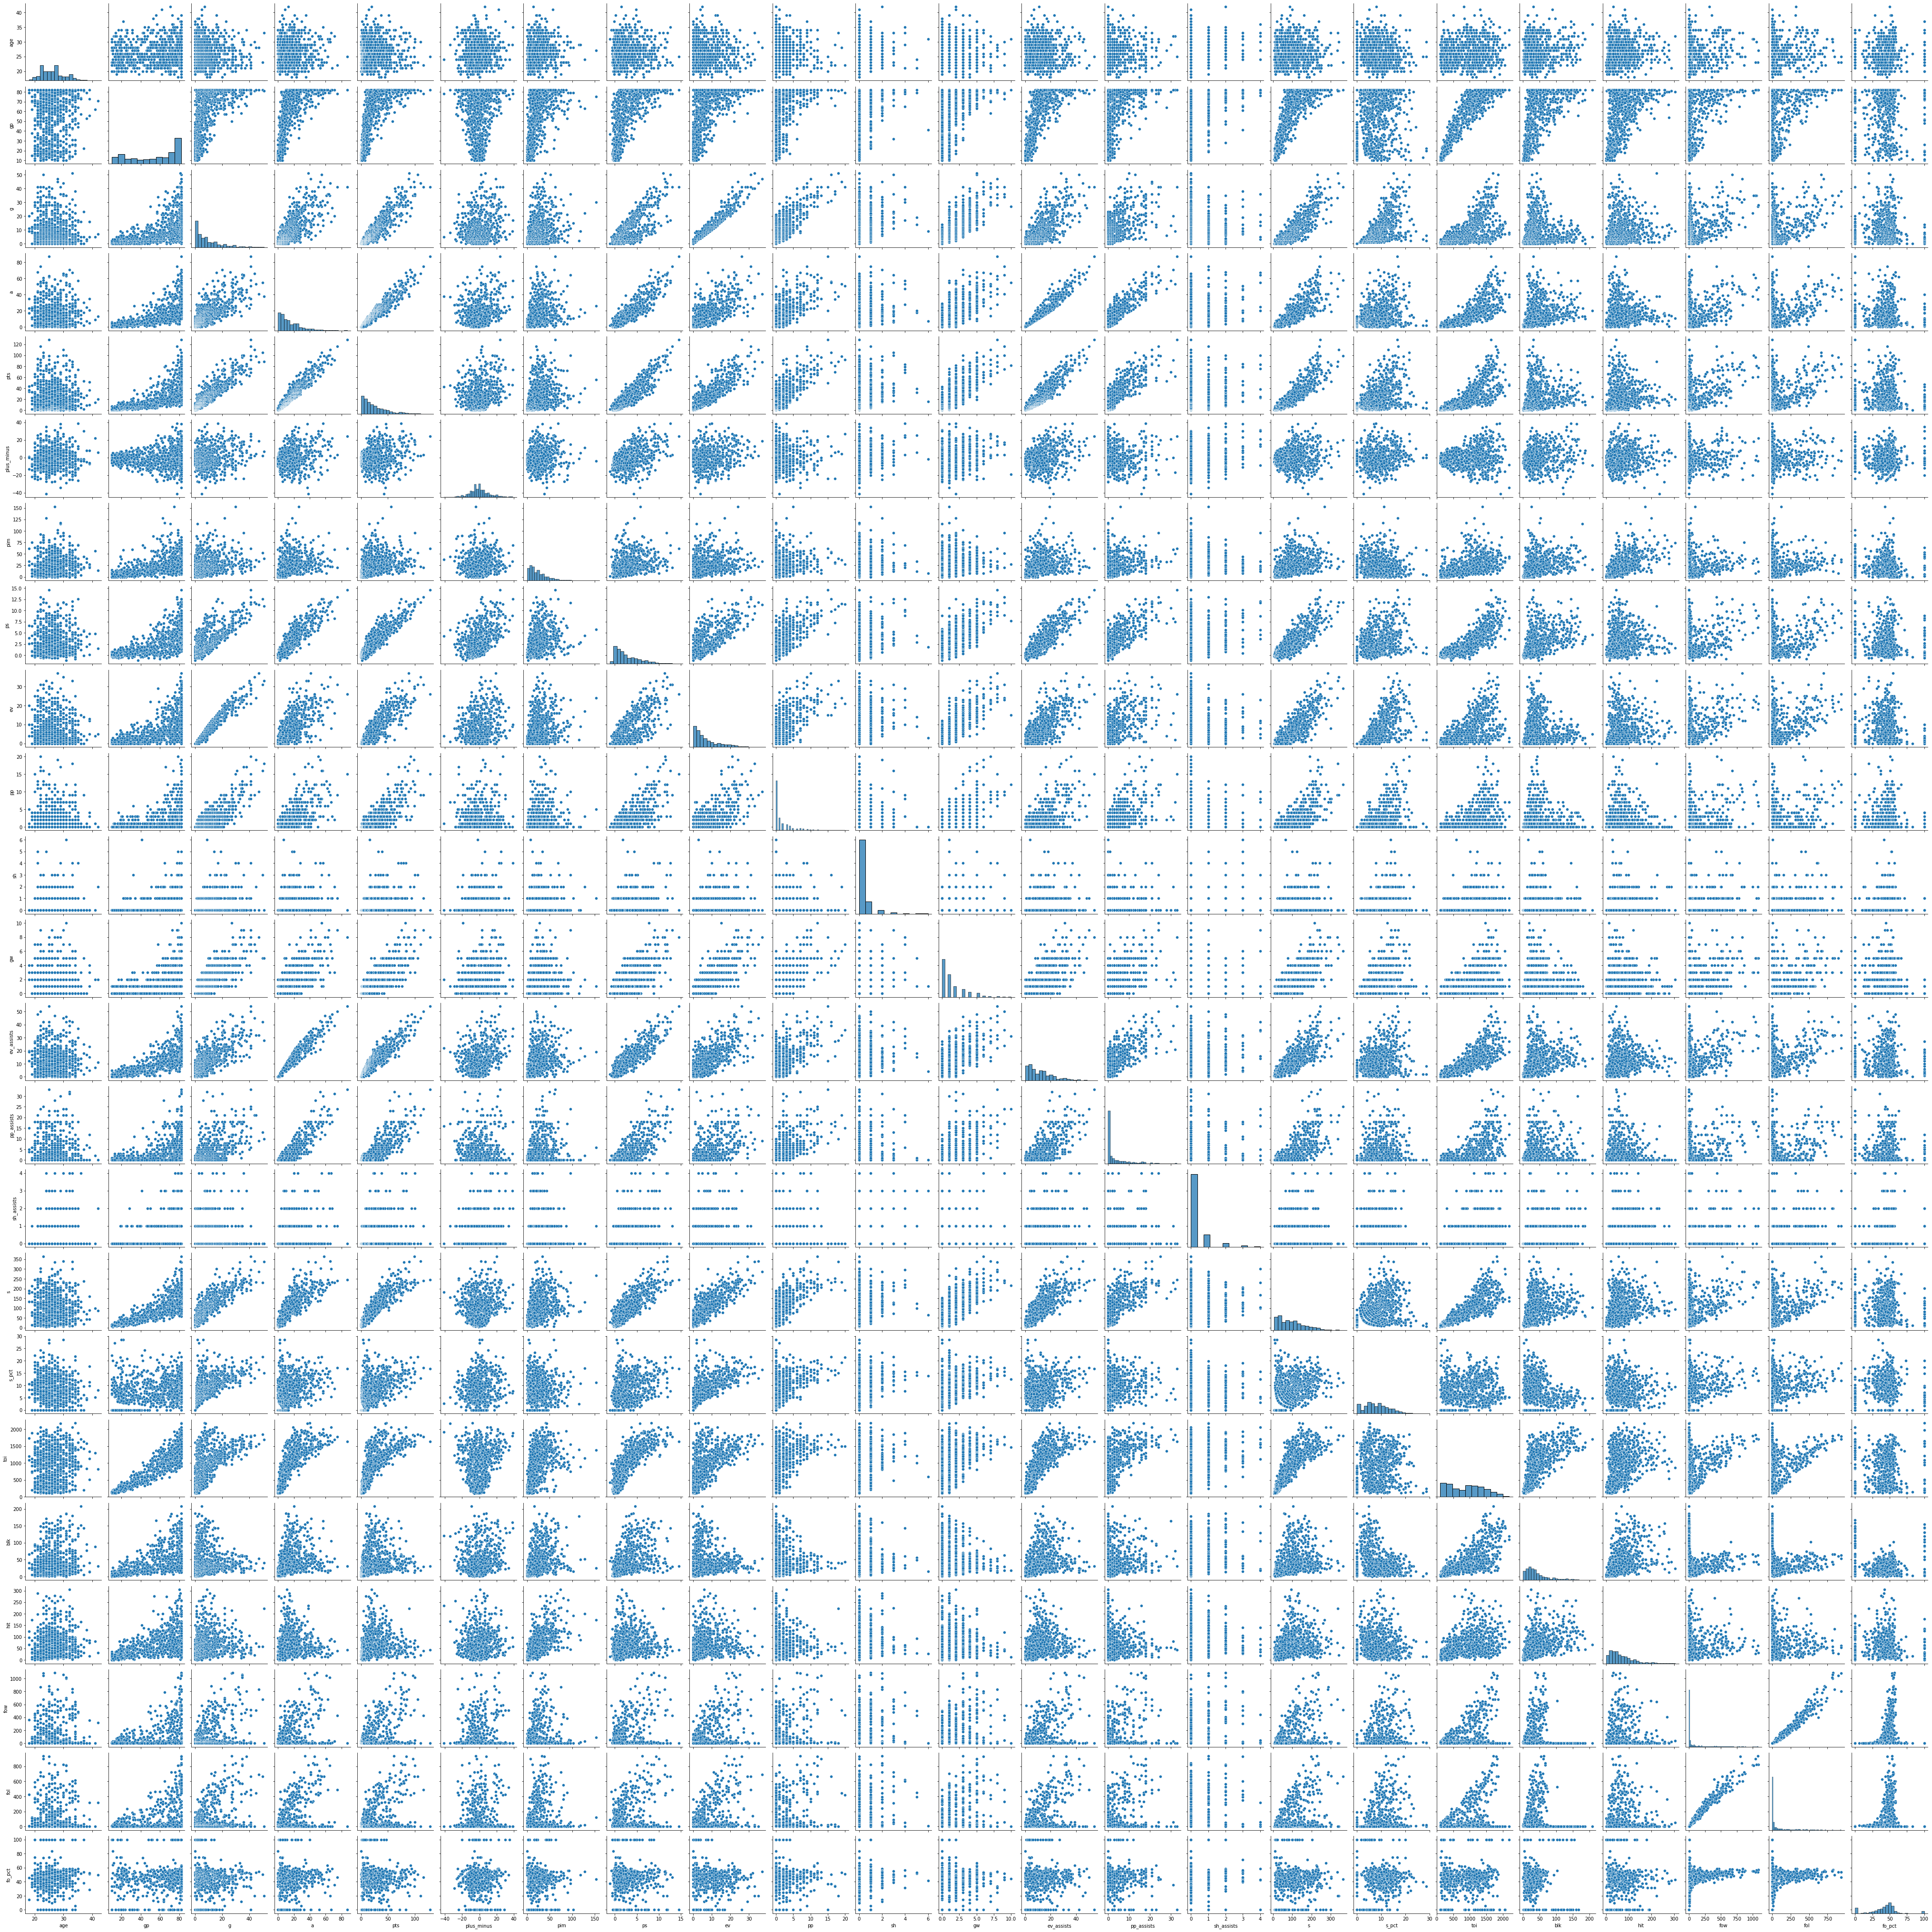

In [9]:
##  pairs plot 
## this might take a few moments!
sns.pairplot(players)

> Hard to read, but should be in the column order AND gives us a high level sense of relationships or distros.

<AxesSubplot:>

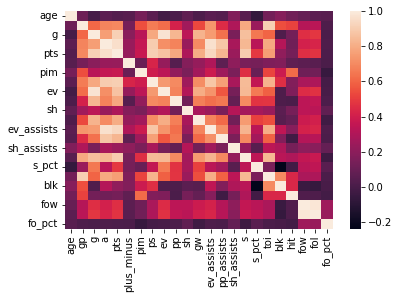

In [10]:
# we can obviously get correlations easily
player_corr = players.corr()
sns.heatmap(player_corr)

# Exercise 2

In [11]:
# replace missing value with zero
# this is because the players never took a face off
players.fo_pct.fillna(0, inplace=True)

/Users/alexandervonschwerdtner/opt/miniconda3/envs/ba820/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [12]:
# confirm that we are all set
players.isna().sum().sum()

0

In [13]:
# adust a few of the stats to rate stats (per games played)
# I will drop the original vars
players['goals_game'] = players.g / players.gp
players['assists_game'] = players.a / players.gp
players['pts_game'] = players.pts / players.gp

players.drop(columns=['g', 'a', 'pts'], inplace=True)

/var/folders/yf/5y3529gn3vdgd3wc6l8vvxgr0000gn/T/ipykernel_3367/2679708672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['goals_game'] = players.g / players.gp
/var/folders/yf/5y3529gn3vdgd3wc6l8vvxgr0000gn/T/ipykernel_3367/2679708672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['assists_game'] = players.a / players.gp
/var/folders/yf/5y3529gn3vdgd3wc6l8vvxgr0000gn/T/ipykernel_3367/2679708672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [14]:
players.head(3)

player  age   tm pos  gp  plus_minus  pim   ps  ev  pp  ...  \
6   Anthony Bitetto   28  MIN   D  18          -8    4 -0.2   0   0  ...   
32      Justin Falk   30  OTT   D  10          -4   11 -0.2   0   0  ...   
34   Trent Frederic   20  BOS   C  15          -4   15 -0.4   0   0  ...   

    s_pct  toi  blk  hit  fow  fol  fo_pct  goals_game  assists_game  pts_game  
6     0.0  237   13   40    0    0     0.0         0.0           0.0       0.0  
32    0.0  129    9   36    0    0     0.0         0.0           0.0       0.0  
34    0.0  141    3   18   41   40    50.6         0.0           0.0       0.0  

[3 rows x 26 columns]

<AxesSubplot:>

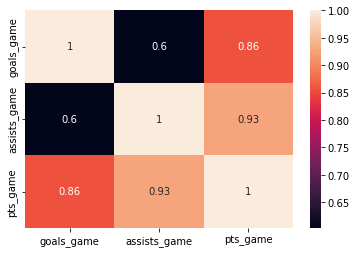

In [15]:
# curious, what is the correlation of these 3 new vars
sns.heatmap(players.iloc[:, -3:].corr(), annot=True)

In [16]:
# with the features all set and no missing data
# construct a datset of stats (numeric data) and attributes (categorical)
player_stats = players.copy()

COLS = ['player','age','tm', 'pos', 'gp', 'ps']

player_atts = player_stats.loc[:, COLS]
player_stats = player_stats.drop(columns=COLS)


In [17]:
# confirm
player_stats.head(3)

plus_minus  pim  ev  pp  sh  gw  ev_assists  pp_assists  sh_assists   s  \
6           -8    4   0   0   0   0           0           0           0  15   
32          -4   11   0   0   0   0           0           0           0   7   
34          -4   15   0   0   0   0           0           0           0  19   

    s_pct  toi  blk  hit  fow  fol  fo_pct  goals_game  assists_game  pts_game  
6     0.0  237   13   40    0    0     0.0         0.0           0.0       0.0  
32    0.0  129    9   36    0    0     0.0         0.0           0.0       0.0  
34    0.0  141    3   18   41   40    50.6         0.0           0.0       0.0

In [18]:
# confirm
player_atts.head(3)

player  age   tm pos  gp   ps
6   Anthony Bitetto   28  MIN   D  18 -0.2
32      Justin Falk   30  OTT   D  10 -0.2
34   Trent Frederic   20  BOS   C  15 -0.4

> Note: that as long as we don't sort the data, we can align the rows later for concatenation to rebuild a dataset!

# Exercise 3

In [19]:
# first, I am going to scale the data given the varying units of measurement
sc = StandardScaler()
ps = sc.fit_transform(player_stats)

ps = pd.DataFrame(ps, columns=player_stats.columns)

In [20]:
# confirm we are looking good
ps.head(3)

plus_minus       pim        ev        pp        sh        gw  ev_assists  \
0   -0.716064 -0.980029 -1.000947 -0.572293 -0.401437 -0.795893   -1.211171   
1   -0.339895 -0.642006 -1.000947 -0.572293 -0.401437 -0.795893   -1.211171   
2   -0.339895 -0.448849 -1.000947 -0.572293 -0.401437 -0.795893   -1.211171   

   pp_assists  sh_assists         s     s_pct       toi       blk       hit  \
0   -0.614123    -0.43007 -1.184276 -1.574127 -1.287236 -0.786435 -0.520222   
1   -0.614123    -0.43007 -1.301520 -1.574127 -1.495927 -0.889933 -0.595610   
2   -0.614123    -0.43007 -1.125654 -1.574127 -1.472739 -1.045180 -0.934859   

        fow       fol    fo_pct  goals_game  assists_game  pts_game  
0 -0.482019 -0.519031 -1.139360   -1.176666     -1.439085 -1.479648  
1 -0.482019 -0.519031 -1.139360   -1.176666     -1.439085 -1.479648  
2 -0.262977 -0.288737  0.830199   -1.176666     -1.439085 -1.479648

In [21]:
# going to do euclidean and cosine distance
diste = pdist(ps.values)
distc = pdist(ps.values, metric="cosine")

In [22]:
# I am going to start with complete linkage
# remember: when we pass in a 1d distance matrix, the metric arg is not applicable
# b/c we already did it 

# put both on the same linkage for now, but you could always generate multiple plots!
hclust_e = linkage(diste)
hclust_c = linkage(distc)

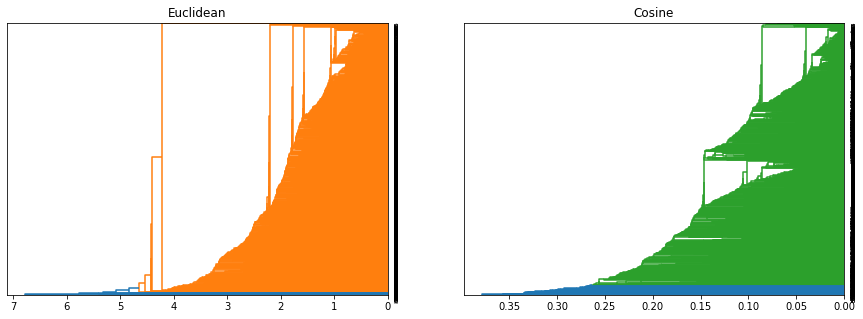

In [23]:
# both plots
LINKS = [hclust_e, hclust_c]
TITLE = ['Euclidean', 'Cosine']

plt.figure(figsize=(15, 5))

# loop and build our plot
for i, m in enumerate(LINKS):
  plt.subplot(1, 2, i+1)
  plt.title(TITLE[i])
  dendrogram(m,
            #  labels = ps.index,
             leaf_rotation=90,
            #  leaf_font_size=10,
             orientation="left")
  
plt.show()

> The plots are hard to read, but we can get a sense of the shape of how the clustering is taking place.  Euclidean is incremental, with larger groups joining late.  Both identified outliers, though cosine appears to suggest more with smaller groups uniting earlier in the algorithm.  I will go with cosine.

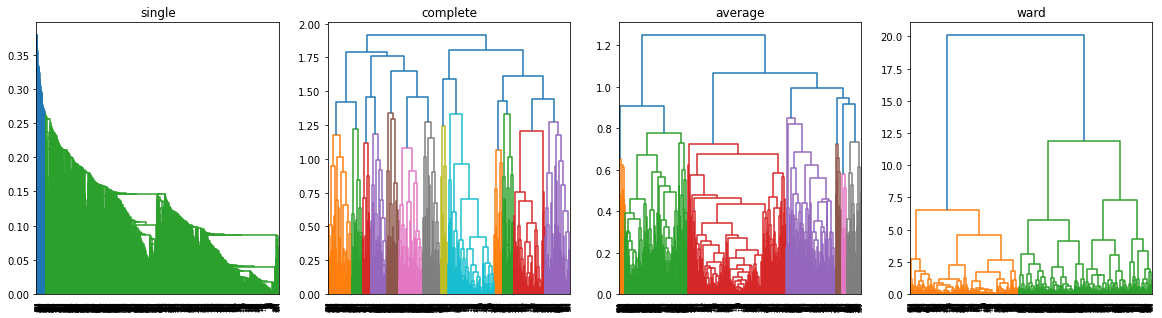

In [24]:
METHODS = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(20,5))


# loop and build our plot
for i, m in enumerate(METHODS):
  plt.subplot(1, 4, i+1)
  plt.title(m)
  dendrogram(linkage(distc, method=m), 
             leaf_rotation=90)
  
plt.show()


> For this business problem, I actually like the segmentation and the "lanes" that are created as part of the complete linkage. So, I will use cosine + complete linkage to form the clusters.  Because there are a number of clusters, I am going to stay with 7, as not not overly condense the segmentation lanes that we see in the plot.

In [25]:
# the labels 
labs = fcluster(linkage(distc, method="complete"), 7, criterion="maxclust")

# confirm
np.unique(labs)

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [26]:
# lets put this back onto the players dataset
players['cluster'] = labs

/var/folders/yf/5y3529gn3vdgd3wc6l8vvxgr0000gn/T/ipykernel_3367/3494262184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['cluster'] = labs


In [28]:
# a quick review
players.head(3)

player  age   tm pos  gp  plus_minus  pim   ps  ev  pp  ...  toi  \
6   Anthony Bitetto   28  MIN   D  18          -8    4 -0.2   0   0  ...  237   
32      Justin Falk   30  OTT   D  10          -4   11 -0.2   0   0  ...  129   
34   Trent Frederic   20  BOS   C  15          -4   15 -0.4   0   0  ...  141   

    blk  hit  fow  fol  fo_pct  goals_game  assists_game  pts_game  cluster  
6    13   40    0    0     0.0         0.0           0.0       0.0        5  
32    9   36    0    0     0.0         0.0           0.0       0.0        5  
34    3   18   41   40    50.6         0.0           0.0       0.0        7  

[3 rows x 27 columns]

In [29]:
# how many players per cluster assignment?
players.cluster.value_counts(dropna=False, sort=False)

5    181
7    192
1    120
6     68
2     82
4    143
3     41
Name: cluster, dtype: int64

> All in all, and as expected per the plot, we see that the clusters are decently balanced.  Its unreleasitc to think we will always have equal numbers across the columns, but ideally we avoid clusters that are really large or small.

> THOUGHT EXERCISE:  What does it possibly say about a dataset when the cluster solutions have segments that are very large or very small relative to the number of records in the full dataset?

# Exercise 4

In [30]:
# lets profile the cluster solutions
player_numeric = players.select_dtypes('number')

clus_profile = player_numeric.groupby("cluster").mean()

clus_profile.T

cluster                 1            2            3            4           5  \
age             27.400000    27.121951    26.585366    26.468531   26.215470   
gp              73.666667    72.512195    73.512195    73.986014   33.535912   
plus_minus       3.575000    -0.792683     3.536585     0.776224   -0.861878   
pim             38.858333    27.975610    55.195122    31.503497   12.834254   
ps               4.863333     3.436585     3.497561     6.286014    1.189503   
ev               4.650000    12.085366    13.756098    16.748252    1.574586   
pp               1.075000     2.512195     2.048780     5.965035    0.254144   
sh               0.191667     0.768293     1.146341     0.307692    0.005525   
gw               1.083333     2.378049     2.609756     3.720280    0.259669   
ev_assists      15.766667    17.585366    14.878049    23.272727    5.408840   
pp_assists       3.841667     4.792683     2.682927    10.657343    0.751381   
sh_assists       0.591667     0.585366     0.829268     0.209790    0.127072   
s              120.925000   132.731707   143.048780   186.160839   41.889503   
s_pct            4.681667    11.241463    11.846341    12.395105    3.908840   
toi           1524.116667  1199.134146  1119.243902  1342.587413  534.845304   
blk            115.500000    42.439024    34.292683    40.664336   33.850829   
hit            110.966667    72.829268   118.902439    65.195804   40.464088   
fow              0.150000   498.792683    69.097561   124.398601    2.408840   
fol              0.266667   463.109756    71.634146   133.993007    3.116022   
fo_pct          10.635833    51.145122    38.651220    37.713287    4.460221   
goals_game       0.080265     0.208711     0.233936     0.310183    0.050875   
assists_game     0.273862     0.314971     0.251167     0.460277    0.172318   
pts_game         0.354128     0.523682     0.485103     0.770460    0.223192   

cluster                6           7  
age            26.867647   25.072917  
gp             58.191176   34.484375  
plus_minus     -2.500000   -3.192708  
pim            30.632353   10.213542  
ps              1.082353    0.614063  
ev              5.529412    3.510417  
pp              0.338235    0.614583  
sh              0.750000    0.020833  
gw              0.911765    0.562500  
ev_assists      7.882353    4.463542  
pp_assists      0.220588    0.729167  
sh_assists      0.500000    0.026042  
s              73.705882   45.614583  
s_pct           9.505882    8.970313  
toi           753.647059  415.395833  
blk            33.764706   15.119792  
hit           121.176471   35.713542  
fow            63.485294   43.338542  
fol            65.514706   49.119792  
fo_pct         38.997059   43.231250  
goals_game      0.115909    0.120070  
assists_game    0.142909    0.150255  
pts_game        0.258818    0.270326

<AxesSubplot:ylabel='cluster'>

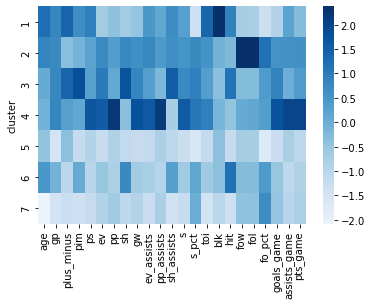

In [31]:
# we can also plot this as a heatmap, but we should normalize the data
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)

cluster_scaled = pd.DataFrame(cluster_scaled, 
                              index=clus_profile.index, 
                              columns=clus_profile.columns)

sns.heatmap(cluster_scaled, cmap="Blues", center=0)

Some example findings from the profiling.  Recall that we only used select variables and that they were scaled!

- It's easy to see that some clusters have higher averages in various metrics than others
- Sometimes a cluster is average, while others tend to overperform/underpeform overall
- I won't go into specifics relative to the game of hockey, but it's not surprising that "leadership" type skills (e.g. faceoff information) stands out.
- Not all of the states were game adjusted (rate stats).  That could be an area of improvement for this exercise.
- If this were a truly robust deliverable, we would want to think about giving each cluster a persona, or one that describes the "typical" player in the assignment.  

> This is a common task for marketing segmentation where we want to characterize each segment via a story that can be used for positioning, etc.



# Exercise 5

Now that we have the assignments, and each player has a team, we can look at how teams are constructed.

In [32]:
# group by team and pivot on cluster, count
team_cluster = pd.crosstab(players.tm, players.cluster)

In [33]:
# this defaults to count, but we normalized the data 

team_cluster = pd.crosstab(players.tm, players.cluster, normalize=0)

In [34]:
team_cluster.head(3)

cluster         1         2         3         4         5         6         7
tm                                                                           
ANA      0.088235  0.088235  0.058824  0.029412  0.264706  0.058824  0.411765
ARI      0.153846  0.076923  0.038462  0.115385  0.192308  0.153846  0.269231
BOS      0.133333  0.033333  0.000000  0.200000  0.200000  0.133333  0.300000

In [35]:
# confirm that each team's row sums to 100
team_cluster.sum(axis=1).head(3)

tm
ANA    1.0
ARI    1.0
BOS    1.0
dtype: float64

In [36]:
teams_raw.head(3)

team abbrev  division  gp   w   l  ol  pts  pts_pct   gf  \
0  Tampa Bay Lightning*    TBL  Atlantic  82  62  16   4  128    0.780  325   
1        Boston Bruins*    BOS  Atlantic  82  49  24   9  107    0.652  259   
2  Toronto Maple Leafs*    TOR  Atlantic  82  46  28   8  100    0.610  286   

    ga   srs   sos  rpt_pct  row  
0  222  1.21 -0.05    0.726   56  
1  215  0.52 -0.01    0.604   47  
2  251  0.42 -0.01    0.573   46

In [37]:
# ok, now that we have the teams by cluster profiles, we can
# add on a metric for success, points

team_pts = teams_raw.loc[:, ["abbrev", "pts"]]

team_pts.head(3)

abbrev  pts
0    TBL  128
1    BOS  107
2    TOR  100

In [38]:
# now lets get the cluster profile aligned
team_cluster2 = team_cluster.reset_index(drop=False, inplace=False)
team_cluster2.rename(columns={'tm':'abbrev'}, inplace=True)
team_cluster2.head(3)

cluster abbrev         1         2         3         4         5         6  \
0          ANA  0.088235  0.088235  0.058824  0.029412  0.264706  0.058824   
1          ARI  0.153846  0.076923  0.038462  0.115385  0.192308  0.153846   
2          BOS  0.133333  0.033333  0.000000  0.200000  0.200000  0.133333   

cluster         7  
0        0.411765  
1        0.269231  
2        0.300000

In [39]:
# finally append the data
team_profile = pd.merge(team_pts, team_cluster2, how="inner")
team_profile.head(3)

abbrev  pts         1         2         3         4         5         6  \
0    TBL  128  0.238095  0.095238  0.095238  0.285714  0.142857  0.142857   
1    BOS  107  0.133333  0.033333  0.000000  0.200000  0.200000  0.133333   
2    TOR  100  0.083333  0.041667  0.125000  0.250000  0.291667  0.000000   

          7  
0  0.000000  
1  0.300000  
2  0.208333

In [40]:
# lets create a compounded key
team_profile['tm_pts'] = team_profile.abbrev + "-" + team_profile.pts.astype('str')

team_profile.head(3)

abbrev  pts         1         2         3         4         5         6  \
0    TBL  128  0.238095  0.095238  0.095238  0.285714  0.142857  0.142857   
1    BOS  107  0.133333  0.033333  0.000000  0.200000  0.200000  0.133333   
2    TOR  100  0.083333  0.041667  0.125000  0.250000  0.291667  0.000000   

          7   tm_pts  
0  0.000000  TBL-128  
1  0.300000  BOS-107  
2  0.208333  TOR-100

<AxesSubplot:ylabel='tm_pts'>

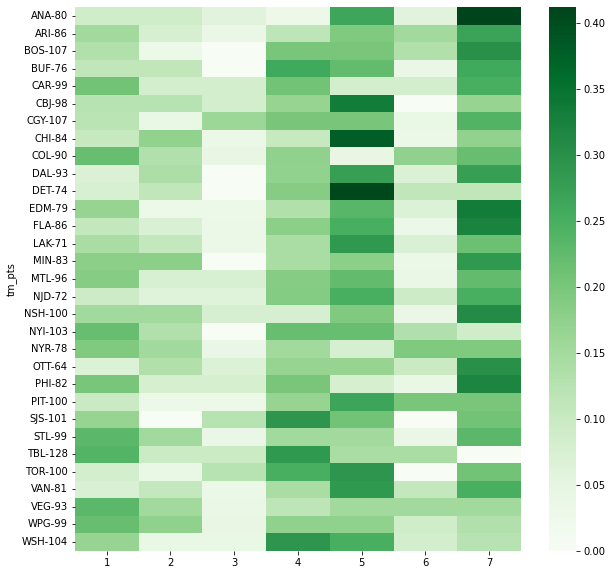

In [41]:
# heatmap the constuction
# hack

plt.figure(figsize=(10, 10))

tmp = team_profile.drop(columns=["abbrev", "pts"])


sns.heatmap(tmp.groupby("tm_pts").mean(), cmap="Greens")


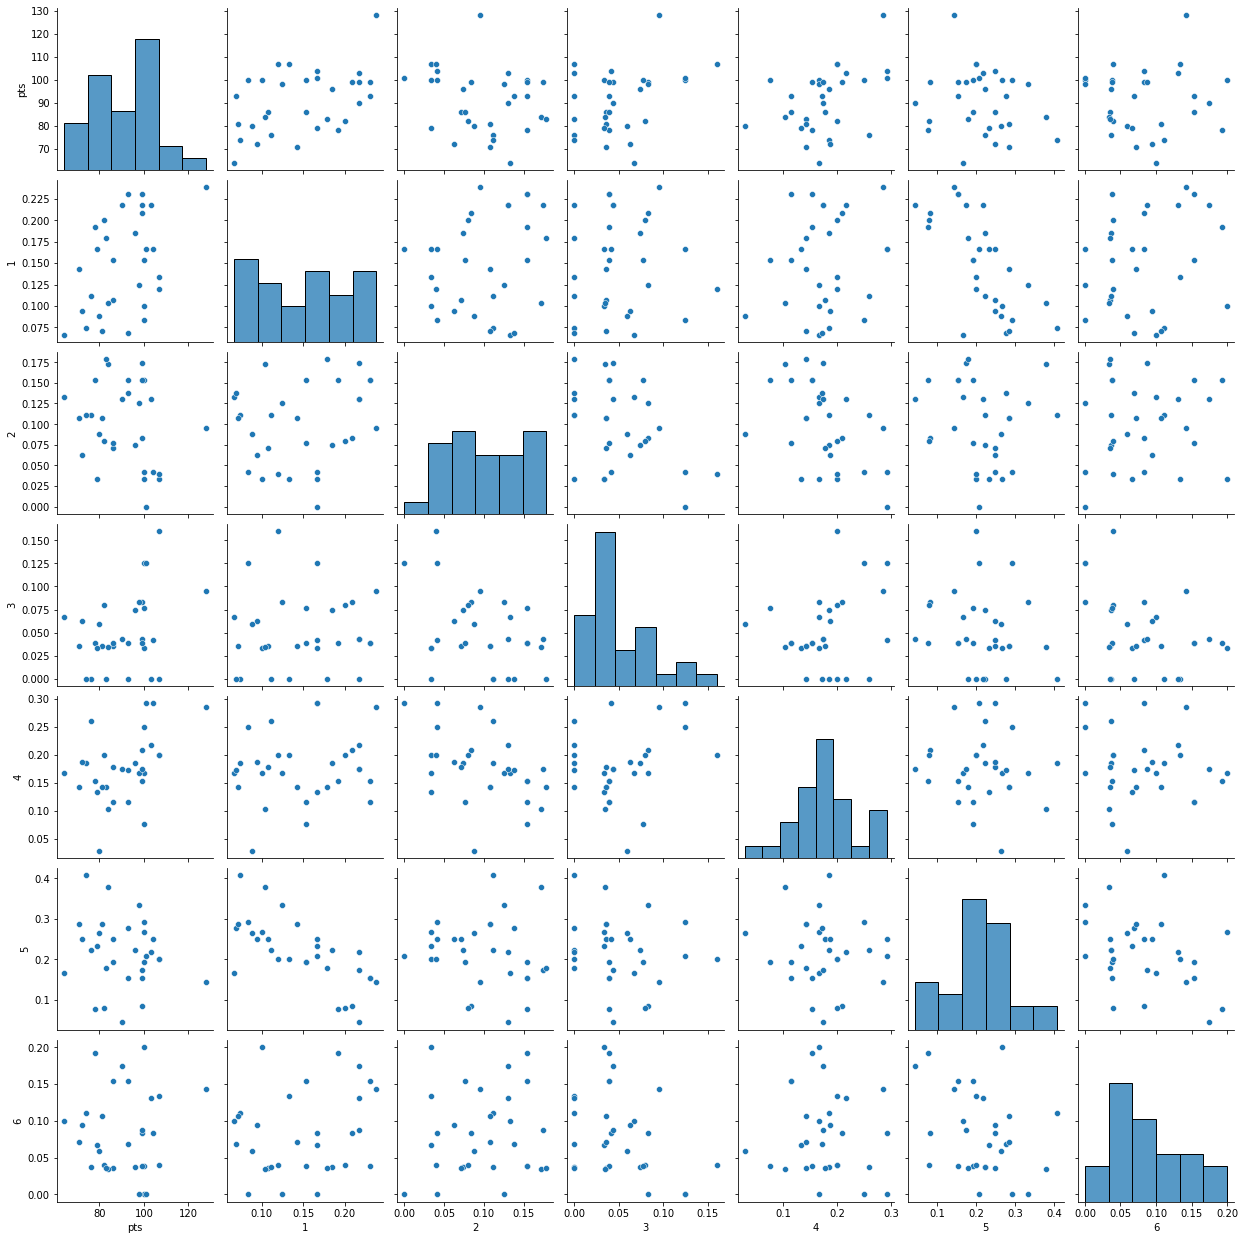

In [42]:
# we can also look at points and cluster distributions for visual patterns of
# what how successful teams were constructed, perhaps there are patterns
sns.pairplot(team_profile.iloc[:, 1:8])

A few notes:


1. STL was the champion in this year, and they were relatively balanced given other teams

2.  BOS lost to STL in the Championship, but they were constructed from clusters 4-7.  Perhaps they should 

3.  From the pairsplot, visually loose relationship between clusters 1 and 4 and the number of points a team had.  Could explain why the Bruins had success, but ultimately lost.  They needed more of cluster 1, which STL had.

# Summary

I added a good amount of depth to what is possible, and I do not expect that you followed each step the way that I did. However, I wanted to highlight a few things:

- Short of a few summaries, we were able to find structure segments within our data set even if you weren’t aware of how the columns are related. This starts to highlight the power of unsupervised machine learning!

- There is no right answer! Analytics and Data Science is an iterative approach. We often have to try different combinations of methods (distance calculations, linkage types etc.) to find a solution that may match what our business challenge is.

- Really understanding the data set and the domain absolutely makes our lives as analysts and data scientists easier. There typically is positive return on our time when we explore and learn more about the domain prior to analyzing data. Consider this for your Capstone Projects!